In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import torch

from src.utils import haversine, radians
from dataset import ObservationsDataset

%load_ext autoreload
%autoreload 2

In [2]:
legend_df = pd.read_csv('data/subway_locations_connections.csv')

def parse_string_array_frame(df, column):
    df[column] = df[column].apply(lambda x : [str(i.strip().upper()[1:-1]) for i in x[1:-1].split(',')])

def parse_float_array_frame(df, column):
    df[column] = df[column].apply(lambda x : [float(i.strip()) for i in x[1:-1].split(',')])

parse_string_array_frame(legend_df, 'dest_name')
parse_string_array_frame(legend_df, 'dest_id')
parse_float_array_frame(legend_df, 'dest_lat')
parse_float_array_frame(legend_df, 'dest_long')

origin_cols = [x for x in legend_df.columns if x.startswith('origin')]
dest_cols = [x for x in legend_df.columns if x.startswith('dest')]

# legend_df[['origin_lat', 'origin_long', 'dest_lat', 'dest_long']] = \
#     legend_df[['origin_lat', 'origin_long', 'dest_lat', 'dest_long']].applymap(lambda x : radians(x))

nodes_df = legend_df[origin_cols]

In [3]:
nodes_df = nodes_df.rename(columns=lambda x : x[len('origin_'):] if x.startswith('origin_') else x)
nodes_df = nodes_df.rename(columns={'long':'lon'})
nodes_df['id'] = nodes_df['name']
nodes_df = nodes_df.set_index('name')
nodes_df

,id,lat,lon
name,,,
1 AV,1 AV,40.730953,-73.981628
103 ST,103 ST,40.799446,-73.968379
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,40.749865,-73.862700
104 ST,104 ST,40.681711,-73.837683
110 ST,110 ST,40.795020,-73.944250
...,...,...,...
WOODLAWN,WOODLAWN,40.886037,-73.878751
WOODSIDE - 61 ST,WOODSIDE - 61 ST,40.745630,-73.902984
WORLD TRADE CENTER,WORLD TRADE CENTER,40.712582,-74.009781


In [4]:
import geopandas as gpd 
from shapely import wkt
from shapely.geometry import Point

nodes_gdf = gpd.GeoDataFrame(nodes_df, crs='epsg:4326')
nodes_gdf = nodes_gdf.set_geometry(
    [Point(row['lon'], row['lat']) for i, row in nodes_gdf[['lat', 'lon']].iterrows()]
)

voronoi_data = pd.read_csv('data/subway_data_voronoi.csv')
voronoi_data['geometry'] = voronoi_data['geometry'].apply(wkt.loads)
voronoi_gdf = gpd.GeoDataFrame(voronoi_data, geometry='geometry', crs='epsg:4326')
nodes_gdf = gpd.sjoin_nearest(nodes_gdf, voronoi_gdf[['geometry', 'population', 'jobs']])
nodes_df = pd.DataFrame(nodes_gdf.drop(columns=['geometry', 'index_right']))
nodes_df = nodes_df[nodes_df['population'] != 0]

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """
/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,


In [5]:
emp = pd.read_csv('data/mta_employment.csv').set_index('origin_name')
emp = emp[emp.columns[-1]].rename('labor_force_rate')
emp = emp.replace('-', None).astype(float) / 100.0
nodes_df = nodes_df.join(emp)
nodes_df

,id,lat,lon,population,jobs,labor_force_rate
name,,,,,,
1 AV,1 AV,40.730953,-73.981628,63146,5499.0,0.734
103 ST,103 ST,40.799446,-73.968379,24164,1100.0,0.641
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,40.749865,-73.862700,48310,706.0,0.718
104 ST,104 ST,40.681711,-73.837683,9781,1656.0,0.622
110 ST,110 ST,40.795020,-73.944250,21003,3590.0,0.619
...,...,...,...,...,...,...
WOODLAWN,WOODLAWN,40.886037,-73.878751,9571,67.0,0.609
WOODSIDE - 61 ST,WOODSIDE - 61 ST,40.745630,-73.902984,27095,7632.0,0.672
WORLD TRADE CENTER,WORLD TRADE CENTER,40.712582,-74.009781,806,0.0,0.783


In [6]:
house_pricing = pd.read_csv('data/mta_housing_salePrice.csv').set_index('origin_name')
house_pricing.drop(columns=[x for x in house_pricing.columns if not x.startswith('Estimate')], inplace=True)
house_pricing.rename(columns= lambda x: 'housing_sales_num_' + x[len('estimate!!'):], inplace=True)
house_pricing = house_pricing.astype(float) / 100.0
house_pricing.fillna(0, inplace=True)
nodes_df = nodes_df.join(house_pricing)
nodes_df

,id,lat,lon,population,jobs,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999",...,"housing_sales_num_Total:!!$175,000 to $199,999","housing_sales_num_Total:!!$200,000 to $249,999","housing_sales_num_Total:!!$250,000 to $299,999","housing_sales_num_Total:!!$300,000 to $399,999","housing_sales_num_Total:!!$400,000 to $499,999","housing_sales_num_Total:!!$500,000 to $749,999","housing_sales_num_Total:!!$750,000 to $999,999","housing_sales_num_Total:!!$1,000,000 to $1,499,999","housing_sales_num_Total:!!$1,500,000 to $1,999,999","housing_sales_num_Total:!!$2,000,000 or more"
name,,,,,,,,,,,,,,,,,,,,,
1 AV,1 AV,40.730953,-73.981628,63146,5499.0,0.734,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00
103 ST,103 ST,40.799446,-73.968379,24164,1100.0,0.641,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,40.749865,-73.862700,48310,706.0,0.718,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.09,0.0,0.09,0.15,0.0,0.00,0.00
104 ST,104 ST,40.681711,-73.837683,9781,1656.0,0.622,0.26,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.13,0.00
110 ST,110 ST,40.795020,-73.944250,21003,3590.0,0.619,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOODLAWN,WOODLAWN,40.886037,-73.878751,9571,67.0,0.609,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00
WOODSIDE - 61 ST,WOODSIDE - 61 ST,40.745630,-73.902984,27095,7632.0,0.672,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00
WORLD TRADE CENTER,WORLD TRADE CENTER,40.712582,-74.009781,806,0.0,0.783,0.57,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.57


In [7]:
emp = pd.read_csv('data/mta_median_income.csv').set_index('origin_name')
median_income = emp['Estimate!!Median income (dollars)!!FAMILIES!!Families'].rename('median_income')
median_income = median_income[median_income != 0]
nodes_df = nodes_df.join(median_income, how='inner')
nodes_df.head(5)

,id,lat,lon,population,jobs,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999",...,"housing_sales_num_Total:!!$200,000 to $249,999","housing_sales_num_Total:!!$250,000 to $299,999","housing_sales_num_Total:!!$300,000 to $399,999","housing_sales_num_Total:!!$400,000 to $499,999","housing_sales_num_Total:!!$500,000 to $749,999","housing_sales_num_Total:!!$750,000 to $999,999","housing_sales_num_Total:!!$1,000,000 to $1,499,999","housing_sales_num_Total:!!$1,500,000 to $1,999,999","housing_sales_num_Total:!!$2,000,000 or more",median_income
1 AV,1 AV,40.730953,-73.981628,63146,5499.0,0.734,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,83750
103 ST,103 ST,40.799446,-73.968379,24164,1100.0,0.641,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,195250
103 ST - CORONA PLAZA,103 ST - CORONA PLAZA,40.749865,-73.862700,48310,706.0,0.718,0.33,0.0,0.0,0.0,...,0.0,0.0,0.09,0.0,0.09,0.15,0.0,0.00,0.0,42328
104 ST,104 ST,40.681711,-73.837683,9781,1656.0,0.622,0.26,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.13,0.0,69375
110 ST,110 ST,40.795020,-73.944250,21003,3590.0,0.619,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,33323


In [8]:
# population = pd.read_csv('data/mta_population.csv').set_index('origin_name')
# population.drop(columns=[x for x in population.columns if not x.startswith('Estimate')], inplace=True)
# population.rename(columns= lambda x: x[len('estimate!!population!! '):], inplace=True)
# population = population[population != 0]
# population.fillna(0, inplace=True)
# nodes_df = nodes_df.join(population, how='inner')
# nodes_df.head(5)

In [9]:
def make_graph_from_df(nodes_df, edges, name='TLC', directed=True):
    G = nx.Graph(directed=directed)
    G.graph['Name'] = name

    G.add_nodes_from(nodes_df.to_dict('index').items())
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [10]:
mta = pd.read_csv('data/subway_2021_ridership.csv')
mta = mta[mta['flag'] == True]
mta['DATE_time'] = pd.to_datetime(mta['DATE_time'])
mta['DATE'] = mta['DATE_time'].dt.normalize()
mta = mta.groupby(['DATE', 'STATION'], as_index=False)['ridership'].sum()
mta['ridership'] = mta['ridership'].astype('float32')
mta

,DATE,STATION,ridership
0,2020-12-26,1 AV,191.0
1,2020-12-26,103 ST,317.0
2,2020-12-26,103 ST-CORONA,703.0
3,2020-12-26,104 ST,20.0
4,2020-12-26,110 ST,239.0
...,...,...,...
102331,2021-12-24,WOODHAVEN BLVD,1546.0
102332,2021-12-24,WOODLAWN,488.0
102333,2021-12-24,WORLD TRADE CTR,233.0
102334,2021-12-24,YORK ST,989.0


In [11]:
mean_target = mta.groupby('STATION').mean().rename(columns={'ridership': 'mean_target'})
mean_weekend_target = mta[mta['DATE'].dt.weekday.isin((5, 6))].groupby(['STATION']).mean() \
    .rename(columns={'ridership': 'mean_weekend_target'})
mean_workday_target = mta[~mta['DATE'].dt.weekday.isin((5, 6))].groupby(['STATION']).mean() \
    .rename(columns={'ridership': 'mean_workday_target'})

nodes_df = nodes_df.join(mean_target, how='inner')
nodes_df = nodes_df.join(mean_weekend_target, how='inner')
nodes_df = nodes_df.join(mean_workday_target, how='inner')
nodes_df

,id,lat,lon,population,jobs,labor_force_rate,housing_sales_num_Total:,"housing_sales_num_Total:!!Less than $10,000","housing_sales_num_Total:!!$10,000 to $14,999","housing_sales_num_Total:!!$15,000 to $19,999",...,"housing_sales_num_Total:!!$400,000 to $499,999","housing_sales_num_Total:!!$500,000 to $749,999","housing_sales_num_Total:!!$750,000 to $999,999","housing_sales_num_Total:!!$1,000,000 to $1,499,999","housing_sales_num_Total:!!$1,500,000 to $1,999,999","housing_sales_num_Total:!!$2,000,000 or more",median_income,mean_target,mean_weekend_target,mean_workday_target
1 AV,1 AV,40.730953,-73.981628,63146,5499.0,0.734,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,83750,497.596161,345.807678,558.311523
103 ST,103 ST,40.799446,-73.968379,24164,1100.0,0.641,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,195250,792.890137,566.384644,883.492310
104 ST,104 ST,40.681711,-73.837683,9781,1656.0,0.622,0.26,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.13,0.00,69375,347.697815,178.317307,415.450012
110 ST,110 ST,40.795020,-73.944250,21003,3590.0,0.619,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,33323,445.208801,251.019226,522.884644
111 ST,111 ST,40.751730,-73.855334,33789,1743.0,0.713,0.08,0.0,0.0,0.0,...,0.0,0.0,0.00,0.08,0.00,0.00,50759,303.337921,169.653839,356.811523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WINTHROP ST,WINTHROP ST,40.656652,-73.950200,17430,7395.0,0.638,0.17,0.0,0.0,0.0,...,0.0,0.0,0.00,0.17,0.00,0.00,75250,597.162537,298.740387,716.992249
WOODHAVEN BLVD,WOODHAVEN BLVD,40.733106,-73.869229,32419,6740.0,0.599,0.22,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,60000,1345.077148,857.798096,1540.741333
WOODLAWN,WOODLAWN,40.886037,-73.878751,9571,67.0,0.609,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,36275,736.689575,456.086548,848.930786
YORK ST,YORK ST,40.701397,-73.986751,10899,13956.0,0.880,0.84,0.0,0.0,0.0,...,0.0,0.0,0.45,0.00,0.00,0.39,250000,1171.057739,870.182678,1291.407715


In [12]:
nodes_df.dropna(inplace=True)
nodes_set = set(nodes_df.index.unique())
print(len(nodes_set))

mta = mta[mta['STATION'].isin(nodes_set)]

233


In [13]:
edges = []
for i, row in legend_df.iterrows():
    if row['origin_name'] not in nodes_set:
        continue
    
    for name, id, lat, lon in zip(*(row[col] for col in dest_cols)):
        # if name not in nodes_set:
        #     nodes_df = nodes_df.append(pd.DataFrame([[name, id, lat, lon]], columns=origin_cols), ignore_index=True)
        #     nodes_set.add(name)
        if name not in nodes_set:
            continue

        olon, olat = row['origin_long'], row['origin_lat']
        dist = float(haversine(olon, olat, lon, lat))

        if dist < 1e-8:
            continue

        edges.append((row['origin_name'], name, {'dist' : dist}))

edges[:5]
        

[('1 AV', '3 AV', {'dist': 30.919180852451866}),
 ('1 AV', 'BEDFORD AV', {'dist': 179.16600798420404}),
 ('103 ST', '96 ST', {'dist': 43.244356226697626}),
 ('103 ST', 'CATHEDRAL PKWY', {'dist': 30.409693548062044}),
 ('104 ST', '111 ST', {'dist': 38.53450231580343})]

In [14]:
for date in mta['DATE'].unique()[:30]:
    ds = ObservationsDataset.from_dataframe_by_day(mta, date)
    date = date.astype('datetime64[D]')
    torch.save(ds, f'datasets/{date}.dat')

In [15]:
G = make_graph_from_df(nodes_df, edges)
print(G.number_of_nodes(), G.number_of_edges())
nx.readwrite.write_gpickle(G, 'data/network.gpickle')

233 221


<AxesSubplot:xlabel='DATE', ylabel='ridership'>

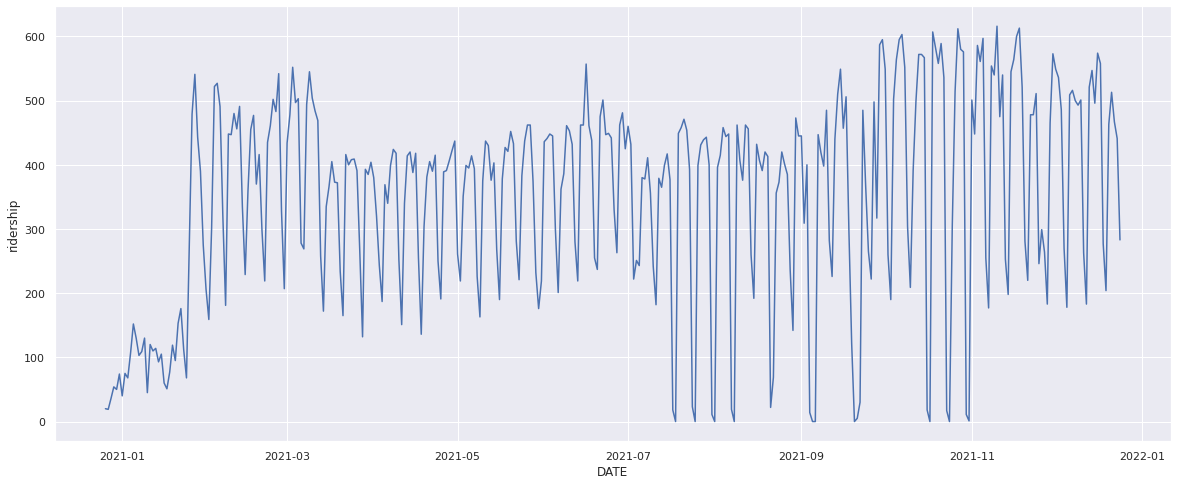

In [16]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=mta[mta['STATION'] == '104 ST'], x='DATE', y='ridership',)

In [17]:
mta_pivot = pd.pivot(data=mta, index='DATE', columns=['STATION'], values='ridership')
mta_pivot.head(5)


STATION,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,135 ST,14 ST,...,UTICA AV,VAN SICLEN AV,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-26,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,1.0,414.0,...,286.0,431.0,53.0,35.0,299.0,224.0,800.0,362.0,7309.0,44.0
2020-12-27,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,0.0,346.0,...,350.0,410.0,46.0,20.0,253.0,188.0,696.0,349.0,447.0,47.0
2020-12-28,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,536.0,773.0,...,575.0,679.0,218.0,55.0,478.0,542.0,1079.0,663.0,867.0,100.0
2020-12-29,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,57.0,752.0,...,563.0,699.0,227.0,48.0,461.0,573.0,1430.0,686.0,896.0,123.0
2020-12-30,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,NaN,756.0,...,577.0,731.0,238.0,52.0,454.0,538.0,1195.0,696.0,894.0,121.0


In [18]:
# if more than 5% of time series for a station is missed -> drop the station
mta_pivot = mta_pivot.loc[:, mta_pivot.isna().sum() / len(mta_pivot) < 0.05]
mta_pivot

STATION,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,14 ST,145 ST,...,UTICA AV,VAN SICLEN AV,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-26,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,414.0,212.0,...,286.0,431.0,53.0,35.0,299.0,224.0,800.0,362.0,7309.0,44.0
2020-12-27,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,346.0,211.0,...,350.0,410.0,46.0,20.0,253.0,188.0,696.0,349.0,447.0,47.0
2020-12-28,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,773.0,333.0,...,575.0,679.0,218.0,55.0,478.0,542.0,1079.0,663.0,867.0,100.0
2020-12-29,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,752.0,394.0,...,563.0,699.0,227.0,48.0,461.0,573.0,1430.0,686.0,896.0,123.0
2020-12-30,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,756.0,411.0,...,577.0,731.0,238.0,52.0,454.0,538.0,1195.0,696.0,894.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,594.0,916.0,463.0,579.0,372.0,156.0,273.0,1741.0,1176.0,624.0,...,709.0,902.0,450.0,62.0,593.0,762.0,2268.0,875.0,1430.0,199.0
2021-12-21,629.0,856.0,513.0,504.0,180.0,176.0,256.0,1699.0,1147.0,595.0,...,664.0,924.0,463.0,75.0,545.0,761.0,1724.0,872.0,1487.0,193.0
2021-12-22,669.0,886.0,467.0,458.0,325.0,157.0,246.0,677.0,1089.0,586.0,...,640.0,884.0,402.0,71.0,566.0,797.0,465.0,769.0,1418.0,203.0


In [19]:
mta_pivot.fillna(mta_pivot.interpolate(method="spline", order=2), inplace=True)
print('NaNs: ', mta_pivot.isna().sum().sum())
mta_pivot.head()

NaNs:  0


STATION,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,14 ST,145 ST,...,UTICA AV,VAN SICLEN AV,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-26,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,414.0,212.0,...,286.0,431.0,53.0,35.0,299.0,224.0,800.0,362.0,7309.0,44.0
2020-12-27,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,346.0,211.0,...,350.0,410.0,46.0,20.0,253.0,188.0,696.0,349.0,447.0,47.0
2020-12-28,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,773.0,333.0,...,575.0,679.0,218.0,55.0,478.0,542.0,1079.0,663.0,867.0,100.0
2020-12-29,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,752.0,394.0,...,563.0,699.0,227.0,48.0,461.0,573.0,1430.0,686.0,896.0,123.0
2020-12-30,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,756.0,411.0,...,577.0,731.0,238.0,52.0,454.0,538.0,1195.0,696.0,894.0,121.0


In [20]:
stations = mta_pivot.columns
stations

Index(['1 AV', '103 ST', '104 ST', '110 ST', '111 ST', '116 ST', '121 ST',
       '125 ST', '14 ST', '145 ST',
       ...
       'UTICA AV', 'VAN SICLEN AV', 'WALL ST', 'WHITLOCK AV', 'WILSON AV',
       'WINTHROP ST', 'WOODHAVEN BLVD', 'WOODLAWN', 'YORK ST', 'ZEREGA AV'],
      dtype='object', name='STATION', length=227)

In [21]:
mta_pivot['weekday'] = mta_pivot.index.to_series().dt.weekday
mta_pivot.head(5)

STATION,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,14 ST,145 ST,...,VAN SICLEN AV,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV,weekday
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-26,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,414.0,212.0,...,431.0,53.0,35.0,299.0,224.0,800.0,362.0,7309.0,44.0,5
2020-12-27,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,346.0,211.0,...,410.0,46.0,20.0,253.0,188.0,696.0,349.0,447.0,47.0,6
2020-12-28,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,773.0,333.0,...,679.0,218.0,55.0,478.0,542.0,1079.0,663.0,867.0,100.0,0
2020-12-29,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,752.0,394.0,...,699.0,227.0,48.0,461.0,573.0,1430.0,686.0,896.0,123.0,1
2020-12-30,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,756.0,411.0,...,731.0,238.0,52.0,454.0,538.0,1195.0,696.0,894.0,121.0,2


In [22]:
mta_pivot['time_idx'] = np.arange(len(mta_pivot.index))

In [23]:
mta_melt = pd.melt(mta_pivot, id_vars=['time_idx', 'weekday'], value_vars=stations)
mta_melt

,time_idx,weekday,STATION,value
0,0,5,1 AV,191.0
1,1,6,1 AV,159.0
2,2,0,1 AV,310.0
3,3,1,1 AV,390.0
4,4,2,1 AV,402.0
...,...,...,...,...
82623,359,0,ZEREGA AV,199.0
82624,360,1,ZEREGA AV,193.0
82625,361,2,ZEREGA AV,203.0
82626,362,3,ZEREGA AV,185.0


In [165]:
mta_pivot.to_csv('data/mta_ridership_pivot.csv', index=False)
mta_melt.to_csv('data/mta_ridership_melt.csv', index=False)